In [366]:
include("../src/HPFEM.jl")

HPFEM

In [382]:
nel = 2
nnodes = nel + 1
idir = Int[]#1,nnodes]
M = 6
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir, true);


In [383]:
dof.nb

2

In [384]:
uexact(x) = sin(x)
rhsfun(x) = 2*sin(x)


rhsfun (generic function with 1 method)

In [385]:
a = 0.0π
b = 2.0π
nodes = collect(linspace(a, b, nnodes));

In [386]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [387]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymMatrix1d);

In [388]:
for e = 1:nel
    Ae = zeros(M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [389]:
solver.Abb.mat

HPFEM.BBSymMatrix{Float64}(2,2,2x2 Array{Float64,2}:
  2.00749   -0.173176
 -0.173176   2.00749 ,#undef)

In [390]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
#Fe[1,1] = uexact(a);
#Fe[2,nel] = uexact(b);

In [391]:
HPFEM.solve!(solver, Fe);

In [392]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

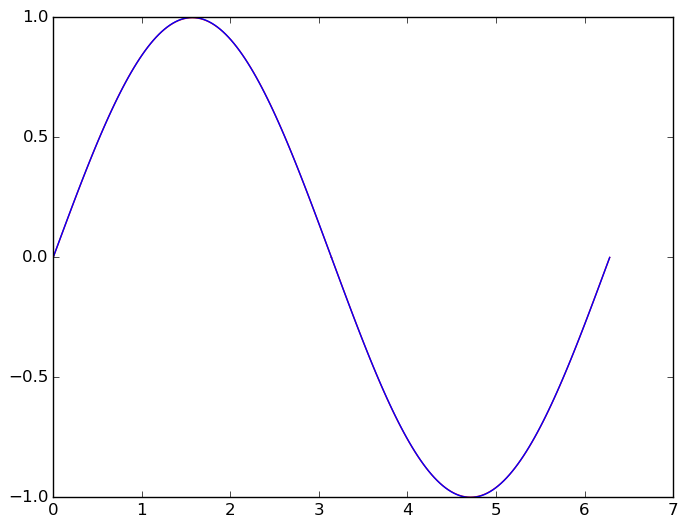

0.0008780458220415399

In [393]:
using PyPlot
maxerr = 0.0
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr